# Onion Price Data Analysis

Compiled for Arrive Logistics by Carson Sprock

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import random

from pydlc import dense_lines

from prophet import Prophet

In [2]:
df = pd.read_csv("data/onion_prices_2020.csv")
df['arrival_date'] = pd.to_datetime(df.arrival_date, dayfirst=True)
df.drop('commodity',axis=1, inplace = True)

# create price spread variable
df['spread'] = df['max_price'] - df['min_price']

# create variables for the week and month
dt_idx_tmp = pd.DatetimeIndex(df['arrival_date'])
df['week'] = pd.PeriodIndex(dt_idx_tmp, freq="W")
df['month'] = pd.PeriodIndex(df['arrival_date'], freq="M")
df['date'] = dt_idx_tmp

df.drop_duplicates(inplace=True)

total_weeks = df.week.nunique()

In [3]:
df.head()

,state,district,market,variety,arrival_date,min_price,max_price,modal_price,spread,week,month,date
0,Andhra Pradesh,Kurnool,Kurnool,Local,2020-01-03,1350,4390,3100.0,3040,2019-12-30/2020-01-05,2020-01,2020-01-03
1,Andhra Pradesh,Kurnool,Kurnool,Local,2020-01-04,1390,4400,3200.0,3010,2019-12-30/2020-01-05,2020-01,2020-01-04
2,Andhra Pradesh,Kurnool,Kurnool,Local,2020-01-06,1460,5150,4310.0,3690,2020-01-06/2020-01-12,2020-01,2020-01-06
3,Andhra Pradesh,Kurnool,Kurnool,Local,2020-01-07,2010,5200,4200.0,3190,2020-01-06/2020-01-12,2020-01,2020-01-07
4,Andhra Pradesh,Kurnool,Kurnool,Local,2020-01-10,1320,4050,3300.0,2730,2020-01-06/2020-01-12,2020-01,2020-01-10


# Contents

1. Data Cleanup and EDA
2. Combining Price Series
3. Forecasting


# 1. Data Cleanup and EDA

Since most forecasting techniques require evenly-spaced time intervals, we work with weekly price average, starting at the market/variety level (the most granular). 

In [4]:
df = df.groupby(by=['state', 'district', 'market', 'variety', 'week']).mean().sort_index()

## Summary Statistics

With so many different time series, may questions arise, such as:
1. Can we forecast each individual time series?
2. Is the data too sparse?
3. Is there some level of aggregation (state, district, market, variety) that would make forecasting tractable? And if so, how do we decide how to combine?


## Basic Summary Statistics

In [5]:
# number of districts, markets and varieties by state
summary_stats = df.reset_index(level=['district', 'market', 'variety']).groupby(by='state').nunique()[['district', 'market', 'variety']]
summary_stats

,district,market,variety
state,,,
Andhra Pradesh,1,2,1
Chattisgarh,4,4,2
Goa,1,1,1
Gujarat,18,27,7
Haryana,21,67,5
Himachal Pradesh,10,25,3
Jammu and Kashmir,6,10,2
Jharkhand,2,2,3
Karnataka,21,49,10


In [6]:
# number of states, districts, markets and varieties
counts = dict()
for val in ['state', 'district', 'market', 'variety']:
    counts.update({val:df.index.get_level_values(val).nunique()})

pd.DataFrame.from_dict(counts, orient='index').rename(columns={0:'Count'})

,Count
state,22
district,315
market,905
variety,21


Next we look at the relationship between the number of districts, markets and varieties within each state. We do this because it seems likely that larger and more populous states will have a larger number of districts and markets and that a larger number of varieties will be sold. The plots below show positive relationships between all these. 

<AxesSubplot:xlabel='district', ylabel='variety'>

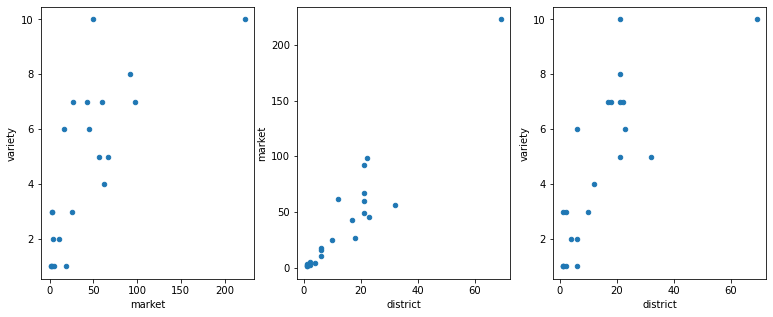

In [7]:
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


summary_stats.plot(x='market', y='variety', kind='scatter', ax=ax)
summary_stats.plot(x='district', y='market', kind='scatter', ax=ax2)
summary_stats.plot(x='district', y='variety', kind='scatter', ax=ax3)

## Missing Data and Completeness

Next we look for missing data in our time series. There are 38 weeks in the series. If there are too many missing points, then we may have to drop that series from the analysis.

The histogram on the left shows the distribution of data completeness as expressed as the ratio of the number of weeks with complete data to the number of weeks in the series (38). The data is at *market* level of aggregation. As we can see, most of the data is at least 80% complete, but there is a significant number of markets that have a large number of missing weeks. 

The bar chart on the right shows the number of markets that have less than 50, 75 and 90 percent of weekly data available. If we were to exclude all markets that had less than 75% of their data complete, we would have to remove over 450 markets from consideration, which is nearly half of the number of markets. 

There could be ligitimate reasons for the missing data, such as markets being closed during parts of the year, or certain varieties only being seasonal. All of these are topics for further exploration. 

<AxesSubplot:>

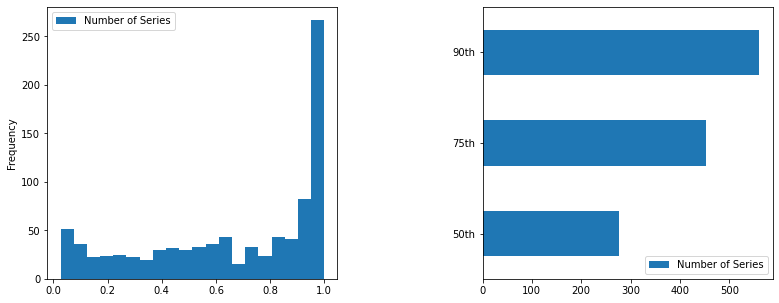

In [8]:
# percent weeks complete

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


fig.subplots_adjust(wspace=0.5)

weekly_coverage_df = df.reset_index(level='week').groupby(by=['state', 'district', 'market']).nunique()[['week']].rename(columns={'week':'Number of Series'}) / total_weeks
weekly_coverage_df.plot(kind='hist', bins=20, ax=ax)

pd.DataFrame.from_dict({
    '50th':(weekly_coverage_df < 0.5).sum(),
    '75th':(weekly_coverage_df < 0.75).sum(),
    '90th':(weekly_coverage_df < 0.90).sum()
}, orient='index').rename(columns={'week':'Markets'}).plot(kind='barh', ax=ax2)

Below we look at the relationship between the number of markets in a district and the average completeness of each market's data. The rationale for looking at the relationship is that more populous and more developed areas of the country might have better recordkeeping. However, the chart shows there doesn't appear to be any relationship. 

<AxesSubplot:xlabel='market', ylabel='Average Completeness'>

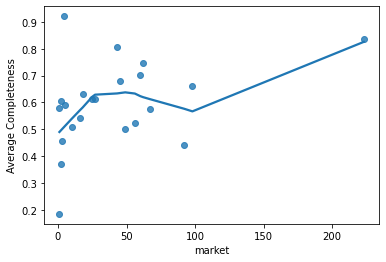

In [9]:
weekly_coverage_combined_df = weekly_coverage_df.groupby(by='state').mean().join(summary_stats).rename(columns={'Number of Series':'Average Completeness'})
sns.regplot(data=weekly_coverage_combined_df, x='market',  y='Average Completeness', lowess=True)

We now remove all price series that are less than 75% complete. 

In [10]:
df = df.join(weekly_coverage_df).rename(columns={'Number of Series':'pct_complete'})
# remove everything below 80% complete
df = df.loc[~(df.pct_complete < 0.75), :]

## Examining Pairwise Relationships

Next we examine pairwise relationships between each variety of onion at the market-level. Specifically, we compute

* correlations between the prices of each variety at each market
* the average price spread between each variety at each market
* the ratio of the average price spread to the maximum price spread

The pairwise correlations are particularly important since we will later be aggregating prices into a single weighted price series. If prices between varieties are correlated, this has a reasonable chance of capturing the aggregate price of onions. 

The average price spread tells us how close together two price series tend to be. 

The ratio of the average weekly price spread to the maximum observed weekly price spread gives us a rough estimate of how much time the the two prices remained near their maximum spread. This gives us a rough measure price divergence over time between two varieties within a market. 

### Interpretation

#### Pairwise Correlation
The histogram of pairwise correlations in the upper-left plot show a positive skew towards 1. This is the expected result and is encouraging for the purposes of creating an aggregate price series through averaging. It says the prices of different varieties within each market are correlated with each other. We could extend this analysis to pairwise prices at higher levels of aggregration, such as the state and district level. 

We also note that price correlation and the mean price spread appear to be negatively correlated. This is also expected since if prices were negatively correlated, we would expect them to diverge and increase the average price spread between them. 

We also see no relationship between correlation and the spread ratio. 

#### Mean Spread

The mean pairwise price spread is right-skewed towards 0, which tells us that in general, the prices of different varieties of onions at the same market tend to be close to each other. 

#### Spread Ratio
The ratio of the mean spread to the maximum observed spread shows that the bulk of the distribution is below 0.5 and centered about 0.25. This means that the mean spread between prices is only 25% of the maximum observed spread, indicating there was a one point a large divergence in prices for most of these pairwise series. 

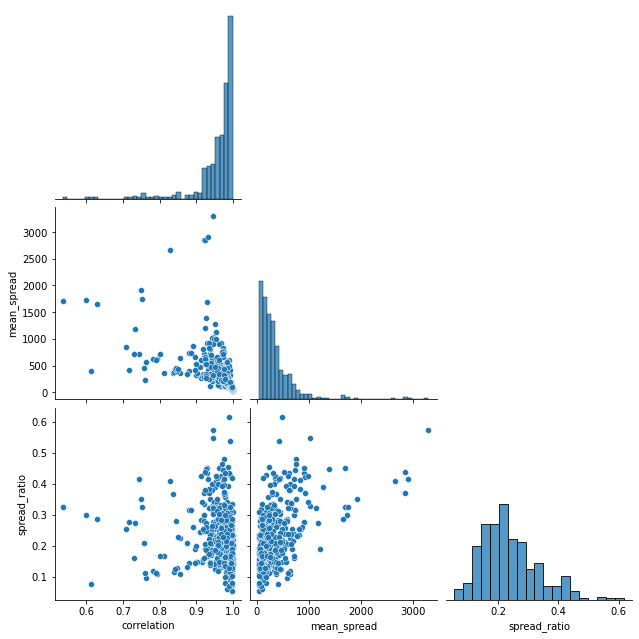

In [11]:
temp_df = df.groupby(by=['state', 'district', 'market', 'week']).mean().sort_index()

from itertools import combinations

idx = pd.IndexSlice
pairwise_values = {}

for _, (state, district) in temp_df.index.to_frame()[['state', 'district']].drop_duplicates().iterrows():
    
    _indexer = idx[state, district]
    markets = temp_df.loc[_indexer].index.get_level_values(0).unique().tolist()
    
    for c in combinations(markets, 2):
        pairs = pd.merge(
            temp_df.loc[idx[state, district, c[0], :], 'modal_price'],
            temp_df.loc[idx[state, district, c[1], :], 'modal_price'],
            on='week'
        )
        
        
        spread = np.abs(pairs.iloc[:, 0] - pairs.iloc[:, 1])
        mean_spread = np.mean(spread)
        
        values = {
            (state, district, c[0], c[1]):{
                'correlation' : pairs.corr().iloc[0][1],
                'mean_spread':mean_spread,
                'spread_ratio': np.nan if mean_spread == 0 else mean_spread / np.max(spread)
            }
            
        }
        
        pairwise_values.update(values)
        
pairs_df = pd.DataFrame.from_dict(pairwise_values, orient='index')

sns.pairplot(pairs_df, height=3, corner=True)

# 2. Combining Price Series

There are two approaches to forecasting the data. We can try and make individual forecasts for various levels of aggregation (state, district, market, variety, etc). To combinatorically simplify things, we try and construct an aggregated price series weighted by both how common each variety is and how "important" each state is based on the number of markets in that state. 

The weighted price series is constructed in two parts. The first part computes a weekly weighted average price for each market where the weights are based on how common the each variety is across the whole data set. The next step aggregates these series into a weighted average price where the weights are based on the number of markets in each state. 

The idea behind the weights is that the price of the most common onion varieties are more important when measuring the effect of price changes on the average consumer. Since it is likely that the number of markets in a state is related to its population, it is reasonable to use the number of markets as a proxy for the size of the state. Large states that contain more people should have a larger influence on the price series because the prices in those states effect the greatest number of people.

The weights are calculated as follows: 

$$
\text{weight for ith variety} = \frac{\text{number of markets selling the $i$th variety}}{\text{total number of markets}}
$$

$$
\text{weight for the jth state} = \frac{\text{number of markets in the $j$th state}}{\text{total number of markets}}
$$

The two bar charts below show the numerators used for each respective calculation and show how each variety and state will be weighted in the new price series. (Note that "Other" is the most common variety, and is likely composed of many different varieties and probably should be excluded or down-weighted in a real analysis). 

<AxesSubplot:ylabel='state'>

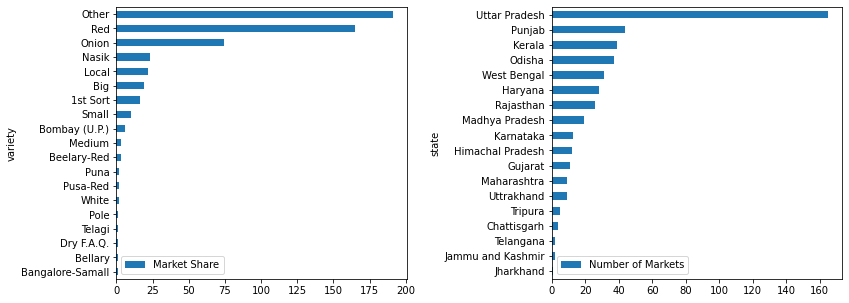

In [12]:
# getting the most common onion variety

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

fig.subplots_adjust(wspace=0.5)

market_share_df = df.reset_index(level='market')[['market']].groupby(by=['variety']).nunique()
market_share_df.sort_values(by='market', ascending=True).rename(columns={'market':'Market Share'}).plot(kind='barh', ax=ax)

markets_per_state_df = df.reset_index(level='market')[['market']].groupby(by=['state']).nunique()
markets_per_state_df.sort_values(by='market', ascending=True).rename(columns={'market':'Number of Markets'}).plot(kind='barh', ax=ax1)

In [13]:
def grouped_weighted_average(group, weight_col, quantity_col):
    d = group[quantity_col]
    w = group[weight_col]
    return (w * d).sum() / w.sum()

# compute weights
state_weight = markets_per_state_df / markets_per_state_df.sum()
variety_weight = market_share_df / market_share_df.sum()

# join weights to dataframe for processing
df = df.join(state_weight, on='state').rename(columns={'market':'state_weight'}).join(variety_weight, on='variety').rename(columns={'market':'variety_weight'})
# compute weighted average of the price for each week using the variety weights
temp_df = df.groupby(by=['state', 'district', 'market', 'week']).apply(grouped_weighted_average, weight_col='variety_weight', quantity_col='modal_price')
# now compute the weighted average of the price series at the state-level
temp_df = pd.DataFrame(temp_df, columns=['w_modal_price']).join(state_weight, on='state').groupby(by=['week']).apply(grouped_weighted_average, weight_col='market', quantity_col='w_modal_price')

<AxesSubplot:title={'center':'Aggregate Onion Price Series'}, xlabel='Week', ylabel='Price'>

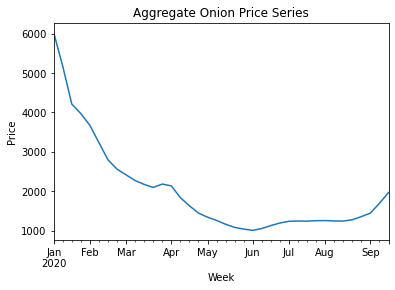

In [14]:
temp_df.plot(title="Aggregate Onion Price Series",ylabel="Price", xlabel="Week")

# 3. Forecasting

For forecasting, we use Prophet (because I've been wanting to try it out for a while). 

In [15]:
p_df = pd.DataFrame.from_dict({'ds':temp_df.index.to_timestamp(), 'y':temp_df.values})

In [16]:
split_point = '2020-08-01'

train = p_df.loc[p_df.ds < split_point]
test = p_df.loc[p_df.ds >= split_point]

#changepoints = ['2020-06-01', '2020-02-10']

In [17]:
n_days_ahead = (test.ds.max() - test.ds.min()).days

The "changepoint_prior_scale" parameter controls the sparsity of the changepoints. Since this data curve is relatively smooth, we do not wish to overfit it by fitting the curve to closely so we set the the prior scale lower than the default (which is 0.5). 

In [18]:
model = Prophet(changepoint_prior_scale=0.1)

In [19]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -0.89229


Iteration  1. Log joint probability =    21.2075. Improved by 22.0998.
Iteration  2. Log joint probability =    40.3326. Improved by 19.1251.
Iteration  3. Log joint probability =    51.9831. Improved by 11.6505.
Iteration  4. Log joint probability =    53.4241. Improved by 1.44104.
Iteration  5. Log joint probability =      53.58. Improved by 0.155877.
Iteration  6. Log joint probability =    53.5895. Improved by 0.00951512.
Iteration  7. Log joint probability =    53.5936. Improved by 0.00408992.
Iteration  8. Log joint probability =    53.7066. Improved by 0.113025.
Iteration  9. Log joint probability =    59.7255. Improved by 6.01886.
Iteration 10. Log joint probability =    59.7363. Improved by 0.0108278.
Iteration 11. Log joint probability =    59.7526. Improved by 0.0163219.
Iteration 12. Log joint probability =    59.7542. Improved by 0.00155027.
Iteration 13. Log joint probability =    59.8356. Improved by 0.081428.
Iteration 14. Log joint probability =    59.9337. Improved by

In [20]:
future_ds = model.make_future_dataframe(periods=n_days_ahead)
predictions = model.predict(future_ds)

#### Results

From the plot below, we can see that the model is underfitting and is not able to capture the change in trend that happens after the forecast. It is possible that we need more data so that if there is a historical pattern of price increases following a period of flat prices. 

Economic price data tends to be driven by external variables and pure time series models such as Prophet will have a hard time detecting change points unless they follow a pattern and since this time series contains no such pattern (because its too short) or is driven by exogenous factors. 

We compute the mean absolute percent error on the test set below. For a good discussion of the limitations of this measure, see https://otexts.com/fpp3/accuracy.html#percentage-errors. 

<AxesSubplot:xlabel='ds', ylabel='y'>

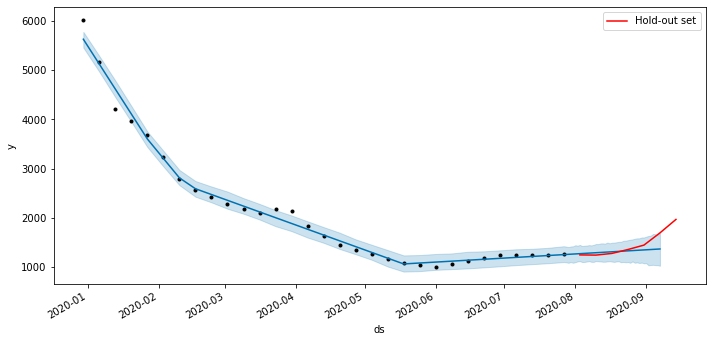

In [21]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)


model.plot(predictions, ax=ax)
test.plot(y='y', x='ds', ax=ax, color='red', label='Hold-out set')

In [22]:
predictions.set_index('ds', drop=True, inplace=True)
test.set_index('ds', drop=True, inplace=True)
combined = predictions.join(test, on='ds', how='inner')[['yhat', 'y']]
mape = np.sum(np.abs((combined.yhat - combined.y) / combined.y))
print("Mean Absolute Percent Error: {mape}".format(mape=mape))

Mean Absolute Percent Error: 0.36637475646128953
